# Wprowadzenie do sieci neuronowych i uczenia maszynowego

## Lab 5a: Podstawowe moduły w PyTorch, sieci konwolucyjne

---

**Prowadzący:** Iwo Błądek, Anna Labijak-Kowalska<br>

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji.


## Cel ćwiczeń:

* zapoznanie się z pojęciem **zbioru danych** i jego charakterystyką,
* wykorzystanie podstawowych warstw neuronowych,
* implementacja procesu uczenia sieci neuronowej + *good practices*

In [1]:
import numpy as np
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124
CUDA available: True


## Zbiór danych

### Wprowadzenie oraz popularne zbiory danych

Odpowiednie przygotowanie zbioru danych odgrywa znaczącą rolę w uczeniu sieci neuronowych. Zazwyczaj zbiory danych zawierają 3 pozbiory:

* treningowy - wykorzystywany do uaktualniania wag modelu neuronowego,
* walidacyjny - do oceny modelu po każdej **epoce**,
* testowy - do porównania modelu z innymi rozwiązaniami.

**Uwaga:** bardzo często popularne zbiory danych nie posiadają wyróżnionego zbioru testowego, ponieważ nie prowadzą tzw. **leaderboard**.

Najpopularniejsze zbiory danych:

* **MNIST**,
* eMNIST,
* Caltech 101/256,
* Cityscapes,
* Kitty,
* LFW Face Dataset,
* ImageNet

Więcej informacji: [wiki](https://en.wikipedia.org/wiki/List_of_datasets_for_machine-learning_research) [kaggle](https://www.kaggle.com/datasets) [google](https://toolbox.google.com/datasetsearch)

### Obsługa zbioru danych w PyTorch

Kod do przetwarzania danych może stać się nieczytelny i trudny do utrzymania; idealnie chcielibyśmy, aby kod związany z naszym zestawem danych był oddzielony od kodu, który odpowiada za uczenie modelu. PyTorch udostępnia dwie klasy do obsługi danych: `torch.utils.data.DataLoader` i `torch.utils.data.Dataset`, które pozwalają na użycie zarówno gotowych zestawów danych, jak i własnych. `Dataset` przechowuje próbki i ich odpowiadające etykiety, a `DataLoader` jest swego rodzaju nakładką na obiekt `Dataset`, umożliwiając łatwy dostęp do próbek - ładowanie danych, dzielenie danych na podzbiory (_ang. batch_). [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

#### Tworzenie zbioru danych

In [2]:
dataset_size = 10

# zbiór danych składający się z losowych obrazków o rozmiarze (32, 32, 3) oraz etykiet po kolei od 0 do dataset_size
x = [np.random.uniform(size=(32, 32, 3)) for _ in range(dataset_size)]
y = [i for i in range(dataset_size)]

tensor_x = torch.Tensor(x)
tensor_y = torch.Tensor(y)

# utworzenie "iteratora" zbioru danych
dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
dataloader = torch.utils.data.DataLoader(dataset)

<ipython-input-2-2ea1c1efc034>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  tensor_x = torch.Tensor(x)


#### Iterowanie po zbiorze danych

In [3]:
for x, y in dataloader:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([1.])
torch.Size([1, 32, 32, 3]) tensor([2.])
torch.Size([1, 32, 32, 3]) tensor([3.])
torch.Size([1, 32, 32, 3]) tensor([4.])
torch.Size([1, 32, 32, 3]) tensor([5.])
torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([9.])


#### Tasowanie

In [6]:
dataloader_shuffled = torch.utils.data.DataLoader(dataset, shuffle=True)

for x, y in dataloader_shuffled:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([2.])
torch.Size([1, 32, 32, 3]) tensor([3.])
torch.Size([1, 32, 32, 3]) tensor([1.])
torch.Size([1, 32, 32, 3]) tensor([9.])
torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([5.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([4.])


#### Mapowanie

In [48]:
class MappedDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, transform_func):
    self.dataset = dataset
    self.transform_func = transform_func

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    data, label = self.dataset[idx]
    return self.transform_func(data, label)


def map(x, y):
  y = y * 2
  return x, y


dataset_mapped = MappedDataset(dataset, map)
dataloader_mapped = torch.utils.data.DataLoader(dataset_mapped)

for x, y in dataloader_mapped:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([0.])
torch.Size([1, 32, 32, 3]) tensor([2.])
torch.Size([1, 32, 32, 3]) tensor([4.])
torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([10.])
torch.Size([1, 32, 32, 3]) tensor([12.])
torch.Size([1, 32, 32, 3]) tensor([14.])
torch.Size([1, 32, 32, 3]) tensor([16.])
torch.Size([1, 32, 32, 3]) tensor([18.])


#### Filtrowanie

In [8]:
class FilteredDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, threshold):
    self.filtered_data = [
      (data, label) for data, label in dataset if label > threshold
    ]

  def __len__(self):
    return len(self.filtered_data)

  def __getitem__(self, idx):
    return self.filtered_data[idx]


dataset_filtered = FilteredDataset(dataset, 5)

dataloader_filtered = torch.utils.data.DataLoader(dataset_filtered)

for x, y in dataloader_filtered:
  print(x.shape, y)

torch.Size([1, 32, 32, 3]) tensor([6.])
torch.Size([1, 32, 32, 3]) tensor([7.])
torch.Size([1, 32, 32, 3]) tensor([8.])
torch.Size([1, 32, 32, 3]) tensor([9.])


#### Grupowanie

In [9]:
dataloader_batch = torch.utils.data.DataLoader(dataset, batch_size=5)

for x, y in dataloader_batch:
  print(x.shape, y)

torch.Size([5, 32, 32, 3]) tensor([0., 1., 2., 3., 4.])
torch.Size([5, 32, 32, 3]) tensor([5., 6., 7., 8., 9.])


#### Składanie wielu operacji na raz

In [10]:
dataset_mix = MappedDataset(dataset, map)
dataset_mix = FilteredDataset(dataset_mix, 6)

dataloader_mix = torch.utils.data.DataLoader(dataset_mix, shuffle=True, batch_size=5)

for x, y in dataloader_mix:
  print(x[0, 0, 0, 0], x.shape, y)

tensor(0.9264) torch.Size([5, 32, 32, 3]) tensor([10., 12., 14., 16., 18.])
tensor(0.9849) torch.Size([1, 32, 32, 3]) tensor([8.])


### Popularne zbiory danych

Biblioteka PyTorch zawiera gotowe funkcje wczytujące dla niektórych zbiorów danych. Większość gotowych zbiorów danych możemy znaleźć w bibliotece *torchvision*. Tutaj możesz znaleźć dokładną listę dostępnych zbiorów danych - [link](https://pytorch.org/vision/stable/datasets.html)

Jednym z popularniejszych zbiorów danych jest MNIST. Jest to zbiór zawierający cyfry pochodzące z pisma odręcznego wraz z ich przypisanymi etykietami ('1', '2', etc.). Poniżej przykładowe pobranie i wykorzystanie zbioru MNIST.

In [11]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:11<00:00, 901kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.62MB/s]


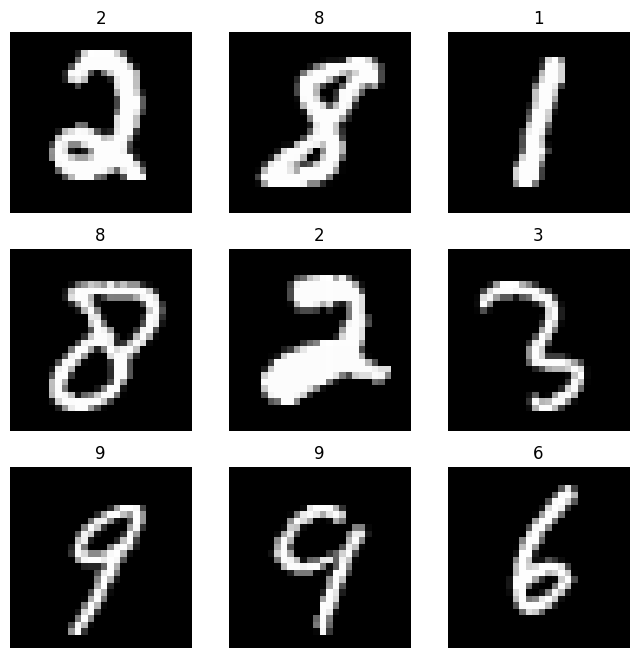

In [12]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Przy projektowaniu sieci neuronowych możemy wyróżnić podstawowe operacje (warstwy), które się powtarzają. Dla wygody, PyTorch zawiera gotowe implementacje najprostszych z nich, oraz udostępnia interfejsy do tworzenia własnych, bardziej skomplikowanych.

Operacje możemy podzielić na:
* **uczalne** - zawierające zmienne uczalne (np. *w* i *b* w warstwie w pełni połączonej),
* **nieuczalne** - takie, które wykonują pewne charakterystyczne działania na danych, jednak nie potrzebują do tego zmiennych, które będą uczone w trakcie propagacji gradientu.

Poniżej zaprezentowane zostały popularne operacje uczalne i nieuczalne.

**Uwaga**
Wszystkie operacje są reprezentowane jako klasy.

## Podstawowe warstwy neuronowe

### Uczalne



Dzięki predefiniowanym warstwom nie ma potrzeby samodzielnej deklaracji nowych zmiennych. Wszystkie zmienne uczone są deklarowane (zgodnie z implementacją danej warstwy) wewnątrz obiektu, a następnie przechowywane.

Do zmiennych uczonych można dostać się poprzez własność *state_dict* (lub *parameters*).

In [13]:
m = torch.nn.Linear(5, 5)

m.state_dict()

OrderedDict([('weight',
              tensor([[-0.0392,  0.3315, -0.3711, -0.2124,  0.1394],
                      [ 0.4319, -0.1261, -0.3279,  0.1321, -0.2011],
                      [-0.3741,  0.3075, -0.4426,  0.2011,  0.3147],
                      [-0.3319, -0.4240, -0.2771,  0.0536, -0.2845],
                      [-0.2033, -0.2596,  0.1179, -0.3716, -0.3345]])),
             ('bias', tensor([-0.2858,  0.0152,  0.3556,  0.0363, -0.1457]))])

#### Linear

Jest to warstwa w pełni połączona, która pobiera jako wejście wektor i produkuje na wyjściu wektor o długości równej rozmiarowi warstwy (liczby neuronów).

In [14]:
# definicja warstwy
linear1 = torch.nn.Linear(8, 2)

# inferencja
x = torch.ones([8])
y = linear1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

# zmienne uczone
state_dict = linear1.state_dict()
print(f"Wagi w warstwie linear: {state_dict['weight']}")
print(f"Bias'y w warstwie linear: {state_dict['bias']}")

torch.Size([8]) torch.Size([2])
Wagi w warstwie linear: tensor([[-0.1980, -0.3147,  0.0993, -0.0121,  0.1321, -0.1977,  0.1530, -0.1874],
        [ 0.1788,  0.1308, -0.1860,  0.0620,  0.1745, -0.2975,  0.1633,  0.1409]])
Bias'y w warstwie linear: tensor([-0.1167,  0.3248])


#### Convolution

Warstwa w pełni połączona dobrze sprawdza się przy danych jednowymiarowych. W przypadku danych wielowymiarowych (jak obrazy) korzystanie z nich byłoby bardzo kosztowne obliczeniowo. Aby wykonać pojedynczą operację *Linear* z 128 neuronami na obrazie o rozmiarach (256, 256, 3) należałoby zadeklarować  256 * 256 * 3 * 128 = 25165824 zmiennych uczonych.

Popularnym rozwiązaniem efektywnego przetwarzania danych wielowymiarowych są operacje konwolucji ([link do wizualizacji](https://github.com/vdumoulin/conv_arithmetic)). Konwolucja (inaczej splot) w sieciach neuronowych intuicyjnie jest, tak samo jak *Linear*, kombinacją liniową danego podobszaru danych wielowymiarowych i zmiennych uczonych (inaczej *kernel*).

Konwolucja w PyTorch posiada szereg parametrów takich jak:
* liczba kanałów wejściowych - liczba kanałów w obrazie wejściowym,
* liczba kanałów wyjściowych - liczba kanałów "wyprodukowana" przez konwolucję,
* kernel_size - rozmiar kernela,
* stride - "rozstrzał" przetwarzanego podobszaru (patrz link do github),
* padding - dopełnienie dodane do wszystkich czterech stron danych wejściowych. Domyślnie: 0,

W porównaniu do przykładu przytoczonego powyżej, konwolucja z 128 filtrami, rozmiarem kernela równym (3, 3), dla takich samych danych wejściowych zawierałaby 3 * 3 * 3 * 128 = 3456, czyli ponad 7281 (!) razy mniej niż w przypadku *Linear*. Ponadto, w przetwarzaniu danych, w których zachodzą lokalne zależności (na obrazie sąsiadujące piksele reprezentują zazwyczaj ten sam obiekt) konwolucja sprawdza się o wiele lepiej niż *Linear*.

In [15]:
# definicja warstwy
conv1 = torch.nn.Conv2d(128, 128, (3, 3), (2, 2), 1)

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 128, 128, 3])
y = conv1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

# zmienne uczone
state_dict = conv1.state_dict()
print(f"Wagi w warstwie conv: {state_dict['weight'].shape}")
print(f"Bias'y w warstwie conv: {state_dict['bias'].shape}")

torch.Size([10, 128, 128, 3]) torch.Size([10, 128, 64, 2])
Wagi w warstwie conv: torch.Size([128, 128, 3, 3])
Bias'y w warstwie conv: torch.Size([128])


### Nieuczalne

Warstwy nieuczalne zazwyczaj wykonują pewne operacje techniczne, typu zmiana kształtu, skalowanie danych, lub są wykorzystywane w **regularyzacji** (o czym będzie mowa na kolejnych zajęciach).

#### Pooling

Jest to jedna z popularniejszych metod regularyzacji, polegająca na wykonaniu pewnej operacji na małym wycinku danych. Przykładowo MaxPooling2D, podobnie jak konwolucja 2D (patrz wizualizacje), wybiera podobszar obrazu o jakichs wymiarach (np. 2x2) a następnie wybiera maksymalny obiekt z tego okna, tworząc nowy obraz (np. zmniejszony 2-krotnie). Istnieją również inne metody poolingu:

* average - z okna obliczana jest średnia,
* median - z okna obliczana jest mediana,
* minimum - z okna wybierana jest najmniejsza wartość,
* itp.

In [16]:
# definicja warstwy
mp1 = torch.nn.MaxPool2d((2, 2), (2, 2))

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 128, 128, 3])
y = mp1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

torch.Size([10, 128, 128, 3]) torch.Size([10, 128, 64, 1])


#### Flatten

Flatten jest prostą funkcją spłaszczającą **każdy element w batchu**. Przykładowo dla grupy 10 obrazów o pewnych wymiarach wyprodukowanych zostanie 10 wektorów (spłaszczonych do wektorów obrazów).

In [17]:
# definicja warstwy
ft1 = torch.nn.Flatten()

# inferencja (przy pierwszym wywołaniu warstwy Linear1 zostaną stworzone zmienne uczone)
x = torch.ones([10, 128, 128, 3])
y = ft1(x)

# rozmiar wejściowego oraz wyjściowego tensora
print(x.shape, y.shape)

torch.Size([10, 128, 128, 3]) torch.Size([10, 49152])


## Proces uczenia sieci neuronowej

Proces uczenia sieci neuronowych składa się z kilku części. Po inicjalizacji modelu oraz zbioru danych następuje uczenie modelu składające się z wielu **epok**. Epoka to pojedyncze przeiterowanie po całym zbiorze danych (podzbiory treningowe i walidacyjne). Przy czym model jest uczony (bład jest propagowany) tylko na zbiorze treningowym. **Nigdy na zbiorach walidacyjnym i testowym.** Proces uczenia sieci neuronowej składa się (najczęściej) następujących części:

1. Inicjalizacja modelu,
2. Inicjalizacja zbioru danych,
3. Pętla treningowa,
  1. Uczenie na zbiorze treningowym (raz!),
  2. Ocena modelu na zbiorze walidacyjnym,
4. Ocena modelu na zbiorze testowym (opcjonalne)

#### Inicjalizacja modelu

**Uwaga:** Jeśli model składa się z następujących po sobie operacji, można opakować go dla wygody w strukturę *Sequential*, tak jak pokazano poniżej.

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [67]:
import torch.nn as nn
from torch.nn.modules.activation import ReLU


class MyModel(nn.Module):
    def __init__(self) -> None:
        """Model który na wejściu otrzymuje obraz a na wyjściu produkuje skalar

        W skład modelu wchodzą 3 warstwy konwolucyjne o rozmiarach 64, 32, 16 (out_channels),
        każda z rozmiarem kernela 5x5 oraz stride 2x2 (czyli obraz po każdej warstwie będzie 2 razy mniejszy)
        potem następuje spłaszczenie obrazu do wektora i przetwarzanie warstwami w pełni połączonymi.
        Wszystkie warstwy (oprócz wyjściowej) korzystają z funkcji aktywacji 'relu'
        """
        super(MyModel, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=2, padding=1),
            ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=1),
            ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=2, padding=1),
            ReLU(),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            ReLU(),
            nn.Linear(in_features=32, out_features=10),
            ReLU(),
            nn.Linear(in_features=10, out_features=10),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        return self.linear_relu_stack(x)


model = MyModel()
print(model)

MyModel(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)


#### Inicjalizacja zbioru danych

Jako zbiór danych wykorzystany zostanie zaprezentowany wcześniej zbiór **MNIST**.

In [68]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [69]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

### Proces uczenia sieci neuronowej

In [70]:
learning_rate = 1e-3
batch_size = 32
epochs = 5

In [71]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [72]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.315616  [   32/60000]
loss: 1.063976  [ 3232/60000]
loss: 0.930766  [ 6432/60000]
loss: 1.059689  [ 9632/60000]
loss: 0.350513  [12832/60000]
loss: 0.411303  [16032/60000]
loss: 0.201484  [19232/60000]
loss: 0.496849  [22432/60000]
loss: 0.204275  [25632/60000]
loss: 0.176738  [28832/60000]
loss: 0.093858  [32032/60000]
loss: 0.315600  [35232/60000]
loss: 0.242938  [38432/60000]
loss: 0.142801  [41632/60000]
loss: 0.214895  [44832/60000]
loss: 0.209402  [48032/60000]
loss: 0.445284  [51232/60000]
loss: 0.111880  [54432/60000]
loss: 0.213967  [57632/60000]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.118716 

Epoch 2
-------------------------------
loss: 0.044347  [   32/60000]
loss: 0.053014  [ 3232/60000]
loss: 0.135591  [ 6432/60000]
loss: 0.194220  [ 9632/60000]
loss: 0.045715  [12832/60000]
loss: 0.428774  [16032/60000]
loss: 0.144221  [19232/60000]
loss: 0.135690  [22432/60000]
loss: 0.277268  [25632/60000]
loss: 0.043741  [28832/60000

#### Zadanie 1

Stwórz zbiór danych (bez podziału na zbiory treningowe, walidacyjne i treningowe) składający się z 10000 elementów, zawierający pary (x, y) danych
dla funkcji **sinus**. Dane x niech będą z zakresu [-2 * PI, 2 * PI], y - odpowiadające im wartości funkcji sinus.

Następnie utwórz providera za pomocą PyTorch Dataset API, który będzie:

* tasował dane
* mapował tak, aby dane x, z zakresu [-2 \* PI, 0), były transformowane do przedziału [0, 2 \* PI)

Podpowiedź: (x + 2PI) % 2PI,
* grupował dane w batche o rozmiarze 32

In [73]:
import numpy as np
from torch.utils.data import TensorDataset, DataLoader


dataset_size = 10000

x = np.linspace(-2 * np.pi, 2 * np.pi, dataset_size)
y = np.sin(x)

tensor_x = torch.tensor(x, dtype=torch.float32)
tensor_y = torch.tensor(y, dtype=torch.float32)


def transform_sinus(x, y):
  x = (x + 2 * np.pi) % 2 * np.pi
  return x, y

dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
mappedDataset = MappedDataset(dataset, transform_sinus)
dataloader = torch.utils.data.DataLoader(mappedDataset, shuffle=True, batch_size=32)

# for x, y in dataloader:
#   print(x, y)

#### Zadanie 2

Stwórz sieć neuronową składającą się z:

* 3 warstw konwolucyjnych (kernel size = 5, liczba filtrów = 128, 64, 32, **bez stride (stride=1)**, aktywacja = relu, **padding='1'**)
* 3 warstw Max Pooling-u, każda znajdująca się za kolejną warstwą konwolucyjną (kernel size = 2, **stride = 2**, padding=1, funkcja aktywacji: relu) (tzn. Conv2d -> MaxPool2d -> Conv2d -> MaxPool2d -> ...),
* 3 warstw w pełni połączonych (rozmiary: 512, 128, **liczba klas**, funkcja aktywacji: relu)

Przetestuj swoją sieć na następujących zbiorach danych:

* Cifar 10
* Cifar 100

In [74]:
import numpy as np
import torch
import torch.nn as nn

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124
CUDA available: True


In [121]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(NeuralNetwork, self).__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, stride=1, padding=2),
            ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            ReLU(),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=5, stride=1, padding=2),
            ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            ReLU(),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2),
            ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            ReLU(),
        )

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            torch.nn.Linear(in_features=32*5*5, out_features=512),
            ReLU(),

            torch.nn.Linear(in_features=512, out_features=128),
            ReLU(),

            torch.nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x


model = NeuralNetwork(10)
print(model)


NeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=800, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [122]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

model = NeuralNetwork(10)

# DONE - init dataset
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [123]:
from torch.utils.data import DataLoader

batch_size = 32

# DONE - init dataloaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [124]:
# TODO - train networks
learning_rate = 1e-3
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297431  [   32/50000]
loss: 1.961807  [ 3232/50000]
loss: 1.906437  [ 6432/50000]
loss: 1.993695  [ 9632/50000]
loss: 1.990707  [12832/50000]
loss: 1.463743  [16032/50000]
loss: 1.478565  [19232/50000]
loss: 1.478493  [22432/50000]
loss: 1.237658  [25632/50000]
loss: 1.524460  [28832/50000]
loss: 1.614998  [32032/50000]
loss: 1.168687  [35232/50000]
loss: 1.376714  [38432/50000]
loss: 1.375384  [41632/50000]
loss: 1.764998  [44832/50000]
loss: 1.185607  [48032/50000]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.274821 

Epoch 2
-------------------------------
loss: 1.192428  [   32/50000]
loss: 1.179512  [ 3232/50000]
loss: 1.002019  [ 6432/50000]
loss: 1.469337  [ 9632/50000]
loss: 1.093521  [12832/50000]
loss: 0.933654  [16032/50000]
loss: 1.346963  [19232/50000]
loss: 1.308478  [22432/50000]
loss: 1.130149  [25632/50000]
loss: 0.883633  [28832/50000]
loss: 1.120854  [32032/50000]
loss: 1.359735  [35232/50000]
loss: 0.980552  [38432/50000

In [125]:
model = NeuralNetwork(100)

training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.600184  [   32/50000]
loss: 4.606565  [ 3232/50000]
loss: 4.601277  [ 6432/50000]
loss: 4.441255  [ 9632/50000]
loss: 4.505960  [12832/50000]
loss: 4.263085  [16032/50000]
loss: 4.299911  [19232/50000]
loss: 4.425410  [22432/50000]
loss: 4.178503  [25632/50000]
loss: 4.266966  [28832/50000]
loss: 4.052618  [32032/50000]
loss: 3.630601  [35232/50000]
loss: 4.560429  [38432/50000]
loss: 4.010098  [41632/50000]
loss: 4.108679  [44832/50000]
loss: 3.927967  [48032/50000]
Test Error: 
 Accuracy: 9.1%, Avg loss: 3.896235 

Epoch 2
-------------------------------
loss: 3.637828  [   32/50000]
loss: 3.663473  [ 3232/50000]
loss: 3.830843  [ 6432/50000]
loss: 3.787503  [ 9632/50000]
loss: 4.036543  [12832/50000]
loss: 3.808629  [16032/50000]
loss: 3.495084  [19232/50000]
loss: 3.475884  [22432/50000]
loss: 3.242941  [25632/50000]
loss: 4.048459  [28832/50000]
loss: 3.770393  [32032/50000]
loss: 3.567184  [35232/50000]
loss: 3.436841  [38432/50000]